In [3]:
#!/usr/bin/env python3
# Copyright 2004-present Facebook. All Rights Reserved.
#  python optim.py -s example1/synth_test.json -e example1
import argparse
import json
import logging
import os
import random
import time
import torch
import numpy as np

import deep_sdf
import deep_sdf.workspace as ws

import pdb

from library.optimiser import *
from library.objective_function import *
from library.post_analysis import *
from library.experiments import *


%matplotlib inline

In [4]:
def adjust_learning_rate(initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every):
    lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def chamfer_distance(p1, p2):
    '''
    Calculate Chamfer Distance between two point sets
    '''
    p1 = p1.unsqueeze(0)
    p2 = p2.unsqueeze(0)

    p1 = p1.repeat(p2.size(1), 1, 1)
    p1 = p1.transpose(0, 1)

    p2 = p2.repeat(p1.size(0), 1, 1)

    # compute distance tensor
    dist = torch.add(p1, torch.neg(p2))
    dist = torch.norm(dist, 2, dim=2)

    dist1, _ = torch.min(dist, dim = 1)
    dist2, _ = torch.min(dist, dim = 0)

    return torch.mean(dist1) + torch.mean(dist2)

class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 100
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False
args = argms()

def getLatentSourceAndTarget(args, source_id, target_id):
    # pick initialization and samples
    # Load collection of all latent codes
    all_codes_path = os.path.join(
        args.experiment_directory,
        ws.latent_codes_subdir,
        'latest.pth')
    all_codes = torch.load(all_codes_path)['latent_codes']['weight']
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    latent = all_codes[source_id].unsqueeze(0).detach().cuda()   #Add .cuda() if you want to run on GPU
    latent.requires_grad = True

    # This is be the target shape (ie objective)
    latent_target = all_codes[target_id].unsqueeze(0).detach().cuda()   #Add .cuda() if you want to run on GPU
    return latent, latent_target

def constructDecoder(args):
    specs_filename = os.path.join(args.experiment_directory, "specs.json")
    specs = json.load(open(specs_filename))
    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])
    latent_size = specs["CodeLength"]
    # Load decoder: this is our black box function
    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(
        os.path.join(
            args.experiment_directory, ws.model_params_subdir, args.checkpoint + ".pth"
        ),
       # map_location=torch.device('cpu') # Remove this if you want to run on GPU
    )
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    # Optionally: put decoder on GPU
    decoder = decoder.module.cuda()
    return decoder


class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 400
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False
args = argms()

In [5]:
if __name__ == "__main__":
    
    torch.manual_seed(0)
    # 0 Initialization
    N_MARCHING_CUBE = 64
    lr= 8e-3
    l2reg= True
    regl2 = 1e-3
    decreased_by = 1.5
    adjust_lr_every = 50
    
    # 1 prepare data
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    ## torus
    target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
    latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
    
    # 2 prepare model
    decoder = constructDecoder(args)
    # 3 prepare optimiser
    optimizer = torch.optim.Adam([latent], lr=lr)

    losses = []
    lambdas = []
    

    objectiveDe = decoder_obj(latent_target, decoder)

    # Use Adam optimizer, with source as starting point, and a loss defined on meshes
    # latent is the input of our function
    print("Starting optimization:")
    start = time.time()
    for e in range(int(args.iterations)):
        #print("latent: ", latent.detach().cpu().numpy())
        
        loss = objectiveDe.func(latent)
        losses.append(loss.detach().cpu().numpy()) 
        #print("loss: ", loss.detach().cpu().numpy())
        
        grad = objectiveDe.dfunc(latent)
        #print("latent grad: ", grad.detach().cpu().numpy())

        #adjust_learning_rate(lr, optimizer, e, decreased_by, adjust_lr_every)
        optimizer.step()
        #print(e, "th iteration\n")
    end = time.time()
end - start

Starting optimization:


57.57914853096008

In [89]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 8e-3,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 100,
         'tol': 1e-6,              
         'verbose': True,
         'record': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats_ada = exp.do()



*******starting optimisation from intitial point:  tensor([-0.3412, -0.4759, -0.1524,  0.0231,  0.1486,  0.3323, -0.1601, -0.1239],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
total evaluatios = 100
gradient at stop position = tensor([[-0.0403,  0.0278, -0.0547, -0.0144, -0.0018, -0.0057,  0.0503,  0.0527]],
       device='cuda:0'),
modified graident = tensor([[-0.1081,  0.2233, -0.2930, -0.1542, -0.2303, -0.0987,  0.4075,  0.3767]],
       device='cuda:0')
found minimum position = tensor([[-0.1705, -0.3181,  0.0271, -0.1400, -0.0010,  0.1682, -0.1373,  0.0339]],
       device='cuda:0', requires_grad=True), found minimum = 0.23344364762306213
distance codomain, domain:  tensor(0.5170, device='cuda:0', grad_fn=<NormBackward0>) tensor(0.2334, device='cuda:0', grad_fn=<NormBackward0>)
Result:  local minimum
found minimum: 0.23344361782073975, minimum position: tensor([[-0.1705, -0.3181,  0.0271, -0.1400, -0.0010,  0.1682, -0.1373,  0.0339]],
       device='cuda:0'), evals: 100
C

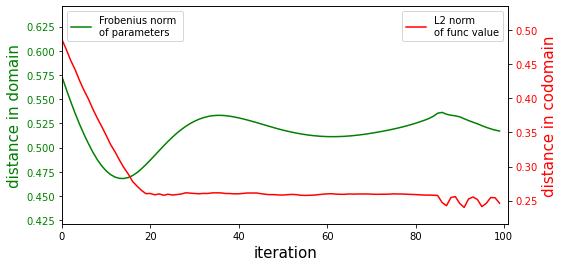

In [90]:
ana_ada = post_analysis_single(stats_ada)
ana_ada.plot_distance()

In [91]:
stats_ada['val'].shape

(101,)

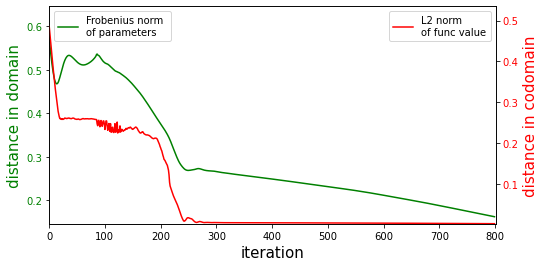

In [91]:
ana_ada = post_analysis_single(stats_ada)
ana_ada.plot_distance()

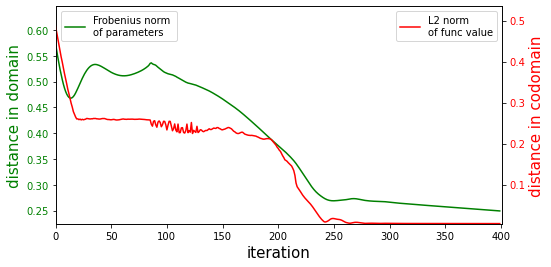

In [5]:
ana = post_analysis_single(stats)
ana.plot_distance()

(0.0, 0.5)

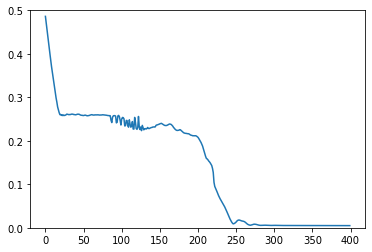

In [6]:
plt.plot(losses)
plt.ylim([0,0.5])

(0.0, 0.5)

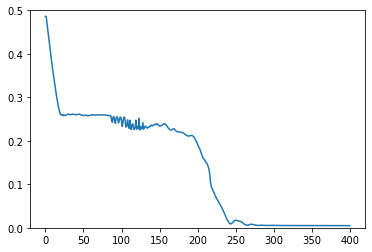

In [9]:
plt.plot(stats['val'])
plt.ylim([0,0.5])

In [8]:
final = torch.tensor(stats['arg'][-1], device=torch.device('cuda:0'))

In [11]:
final.requires_grad_(True)

tensor([[-0.1705, -0.3181,  0.0271, -0.1400, -0.0010,  0.1682, -0.1373,  0.0339]],
       device='cuda:0', requires_grad=True)

In [65]:
import plyfile
def write_verts_faces_to_file(verts, faces, ply_filename_out):

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(verts[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")

    ply_data = plyfile.PlyData([el_verts, el_faces])
    logging.debug("saving mesh to %s" % (ply_filename_out))
    ply_data.write(ply_filename_out)

In [66]:
mesh = __import__('deep_sdf.mesh')
N_MARCHING_CUBE = 64
verts, faces = mesh.create_mesh_optim(decoder, finalcma.cuda(), N=N_MARCHING_CUBE, max_batch=int(2 ** 18))
write_verts_faces_to_file(verts, faces, "data/finalcma.ply")

In [4]:
final1 = torch.tensor([[-0.1002, -0.3736,  0.1695,  0.1200,  0.1178,  0.1962,  0.1246, -0.0640]])
final2 = torch.tensor([[-0.0935, -0.3092,  0.1673,  0.1764,  0.0734,  0.2136,  0.1456, -0.0942]])

In [6]:
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)

In [8]:
torch.norm(final2 - latent_target.cpu())

tensor(0.0869)

In [9]:
torch.norm(final1 - latent_target.cpu())

tensor(0.1626)

In [54]:
torch.norm(finalcma - latent_target.cpu())

tensor(0.4957)

In [52]:
latent_target

tensor([[-0.0562, -0.2882,  0.1230,  0.2264,  0.0941,  0.1983,  0.1402, -0.1180]],
       device='cuda:0')

In [53]:
latent

tensor([[-0.3412, -0.4759, -0.1524,  0.0231,  0.1486,  0.3323, -0.1601, -0.1239]],
       device='cuda:0')

In [50]:
finalcma = torch.tensor([0.01120337, -0.31564802,  0.09386248, -0.17916831,  0.17017406,  0.32104713,
  0.20556374, -0.34165084])

(0.0, 0.5)

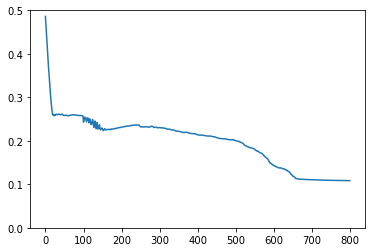

In [160]:
plt.plot(losses)
plt.ylim([0,0.5])

In [ ]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

In [105]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
latent = latent.detach()

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
optParas ={'x0': latent,
           'std': torch.ones((8,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 1e-1, 
           'adjust_func': do_nothing(), 
           'record': True, 
           'max_iter': 400,
           'cluster_size': 6,
           'verbose': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats = exp.do()

distance codomain, domain:  tensor(0.2497, device='cuda:0') tensor(0.0055, device='cuda:0')
CPU times: user 8min 14s, sys: 38.5 s, total: 8min 52s
Wall time: 26.6 s


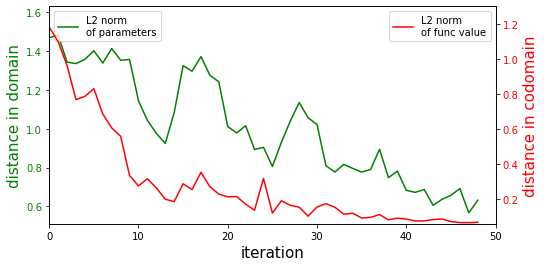

In [106]:
ana = post_analysis_single(stats)
ana.plot_distance()

In [ ]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 8e-3,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 10,
         'tol': 1e-6,              
         'verbose': True,
         'record': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats_ada = exp.do()